In [1]:
import zipfile


zip_path = '/content/drive/MyDrive/clothes_tryon_dataset.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [1]:
input_image_path = "/content/dataset/clothes_tryon_dataset/train/image/00000_00.jpg"

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


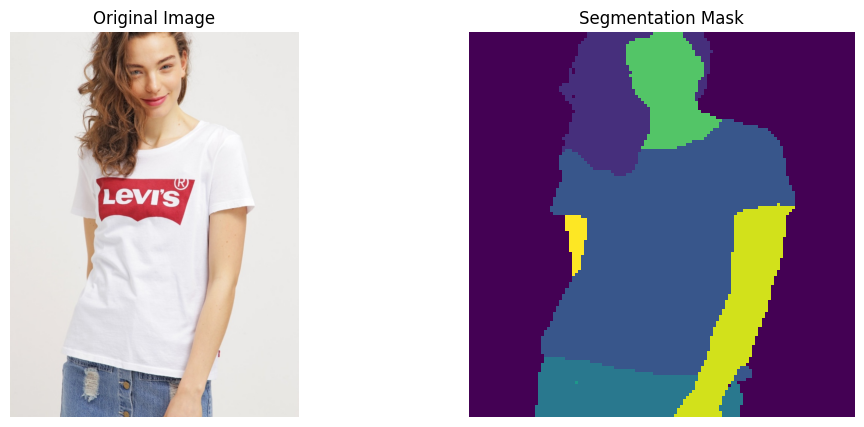

In [2]:
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt


model = SegformerForSemanticSegmentation.from_pretrained(
    "matei-dorian/segformer-b5-finetuned-human-parsing"
)
processor = SegformerImageProcessor.from_pretrained(
    "matei-dorian/segformer-b5-finetuned-human-parsing"
)

img_path = input_image_path
image = Image.open(img_path).convert("RGB")

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
seg = logits.argmax(dim=1)[0].cpu().numpy()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(seg)
plt.title("Segmentation Mask")
plt.axis("off")
plt.show()


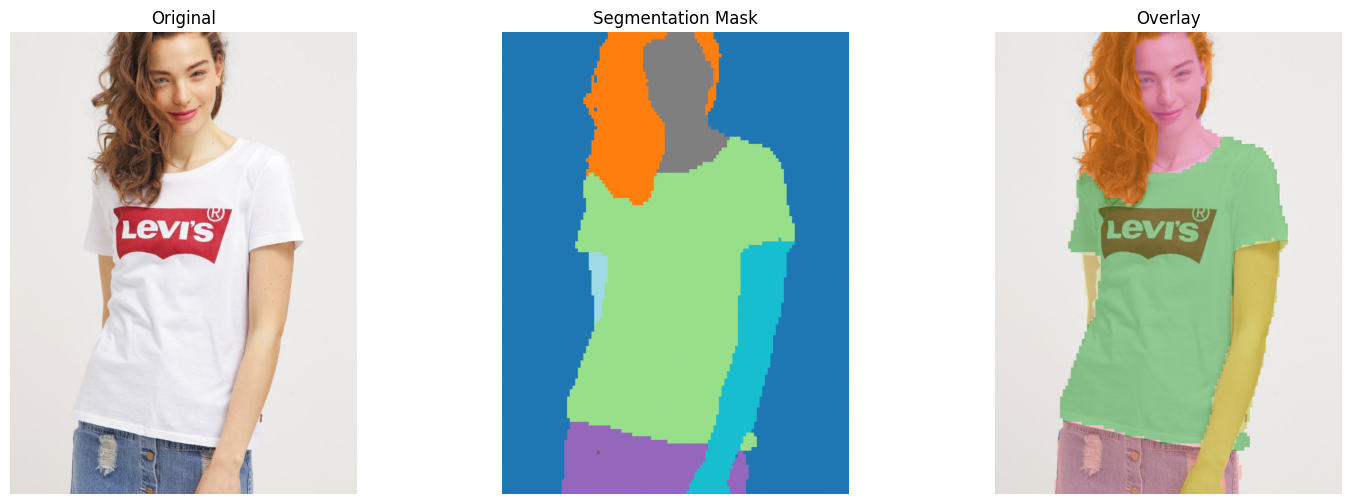

Labels present:
 - Background (id 0)
 - Hair (id 2)
 - Upper-clothes (id 4)
 - Pants (id 6)
 - Belt (id 8)
 - Face (id 11)
 - Left-arm (id 14)
 - Right-arm (id 15)


In [3]:
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

atr_labels = [
    "Background", "Hat", "Hair", "Sunglasses", "Upper-clothes", "Skirt", "Pants", "Dress", "Belt",
    "Left-shoe", "Right-shoe", "Face", "Left-leg", "Right-leg", "Left-arm", "Right-arm", "Bag", "Scarf"
]
num_classes = len(atr_labels)

model = SegformerForSemanticSegmentation.from_pretrained(
    "matei-dorian/segformer-b5-finetuned-human-parsing"
)
processor = SegformerImageProcessor.from_pretrained(
    "matei-dorian/segformer-b5-finetuned-human-parsing"
)

img_path = input_image_path
image = Image.open(img_path).convert("RGB")

inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)


logits = outputs.logits
mask = logits.argmax(dim=1)[0].cpu().numpy()


mask_img_resized = Image.fromarray(mask.astype(np.uint8)).resize(image.size, resample=Image.NEAREST)
mask = np.array(mask_img_resized)


mask_img = Image.fromarray((mask * (255 // num_classes)).astype(np.uint8))
mask_img.save("/content/mask.png")

colors = plt.cm.tab20(np.linspace(0, 1, num_classes))[:, :3]
overlay = np.array(image) / 255.0
alpha = 0.5

for class_id in np.unique(mask):
    if class_id == 0:
        continue
    overlay[mask == class_id] = (
        alpha * colors[class_id] + (1 - alpha) * overlay[mask == class_id]
    )


plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap='tab20')
plt.title("Segmentation Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


unique_classes = np.unique(mask)
print("Labels present:")
for idx in unique_classes:
    print(f" - {atr_labels[idx]} (id {idx})")


In [4]:
import numpy as np
from PIL import Image

LEFT_ARM_ID = 14
RIGHT_ARM_ID = 15


left_arm_mask = (mask == LEFT_ARM_ID).astype(np.uint8) * 255
right_arm_mask = (mask == RIGHT_ARM_ID).astype(np.uint8) * 255

arms_mask = np.logical_or(mask == LEFT_ARM_ID, mask == RIGHT_ARM_ID).astype(np.uint8) * 255

Image.fromarray(arms_mask).save("exposed_arms_mask5.png")



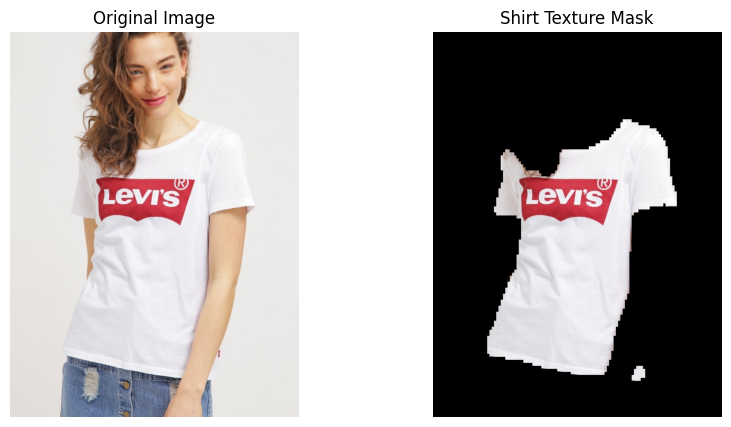

In [8]:
from PIL import Image
import numpy as np


image = Image.open(input_image_path).convert("RGB")
image = np.array(image)
mask = np.array(mask)

shirt_texture = np.zeros_like(image)
UPPER_CLOTHES_ID = 4

shirt_texture[mask == UPPER_CLOTHES_ID] = image[mask == UPPER_CLOTHES_ID]


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Shirt Texture Mask")
plt.imshow(shirt_texture)
plt.axis("off")

plt.show()

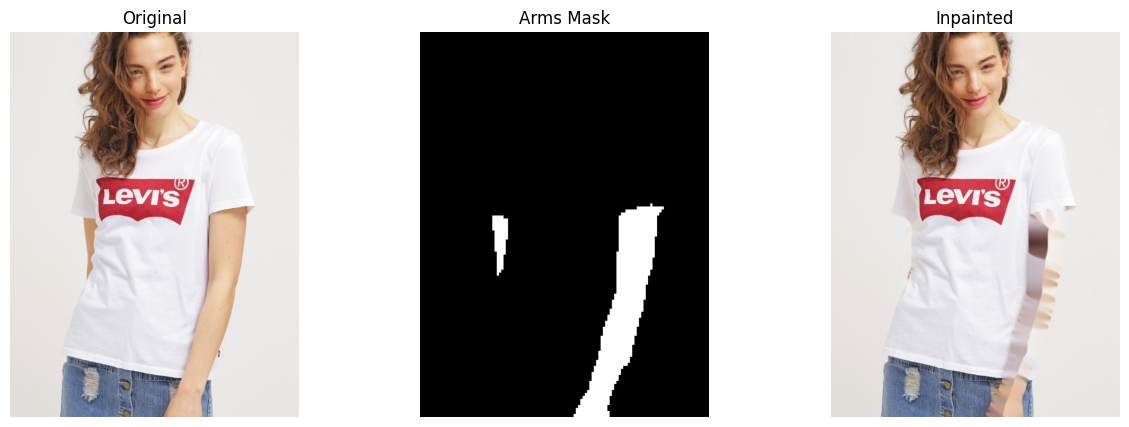

In [5]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image = np.array(Image.open(input_image_path).convert("RGB"))
arms_mask = "/content/exposed_arms_mask5.png"
mask = np.array(Image.open(arms_mask))



image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

inpainted_bgr = cv2.inpaint(image_bgr, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

inpainted_rgb = cv2.cvtColor(inpainted_bgr, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(image)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Arms Mask")
plt.imshow(mask, cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Inpainted")
plt.imshow(inpainted_rgb)
plt.axis("off")

plt.show()




In [12]:
!pip install -U "huggingface_hub>=0.28.1" "diffusers>=0.27.2" "transformers>=4.40.0" accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [8]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForInpainting.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16
)
pipeline.enable_model_cpu_offload()


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [22]:
import torch
torch.cuda.empty_cache()


In [18]:
init_image = load_image(input_image_path).convert("RGB")
mask_image = load_image(arms_mask).convert("RGB")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

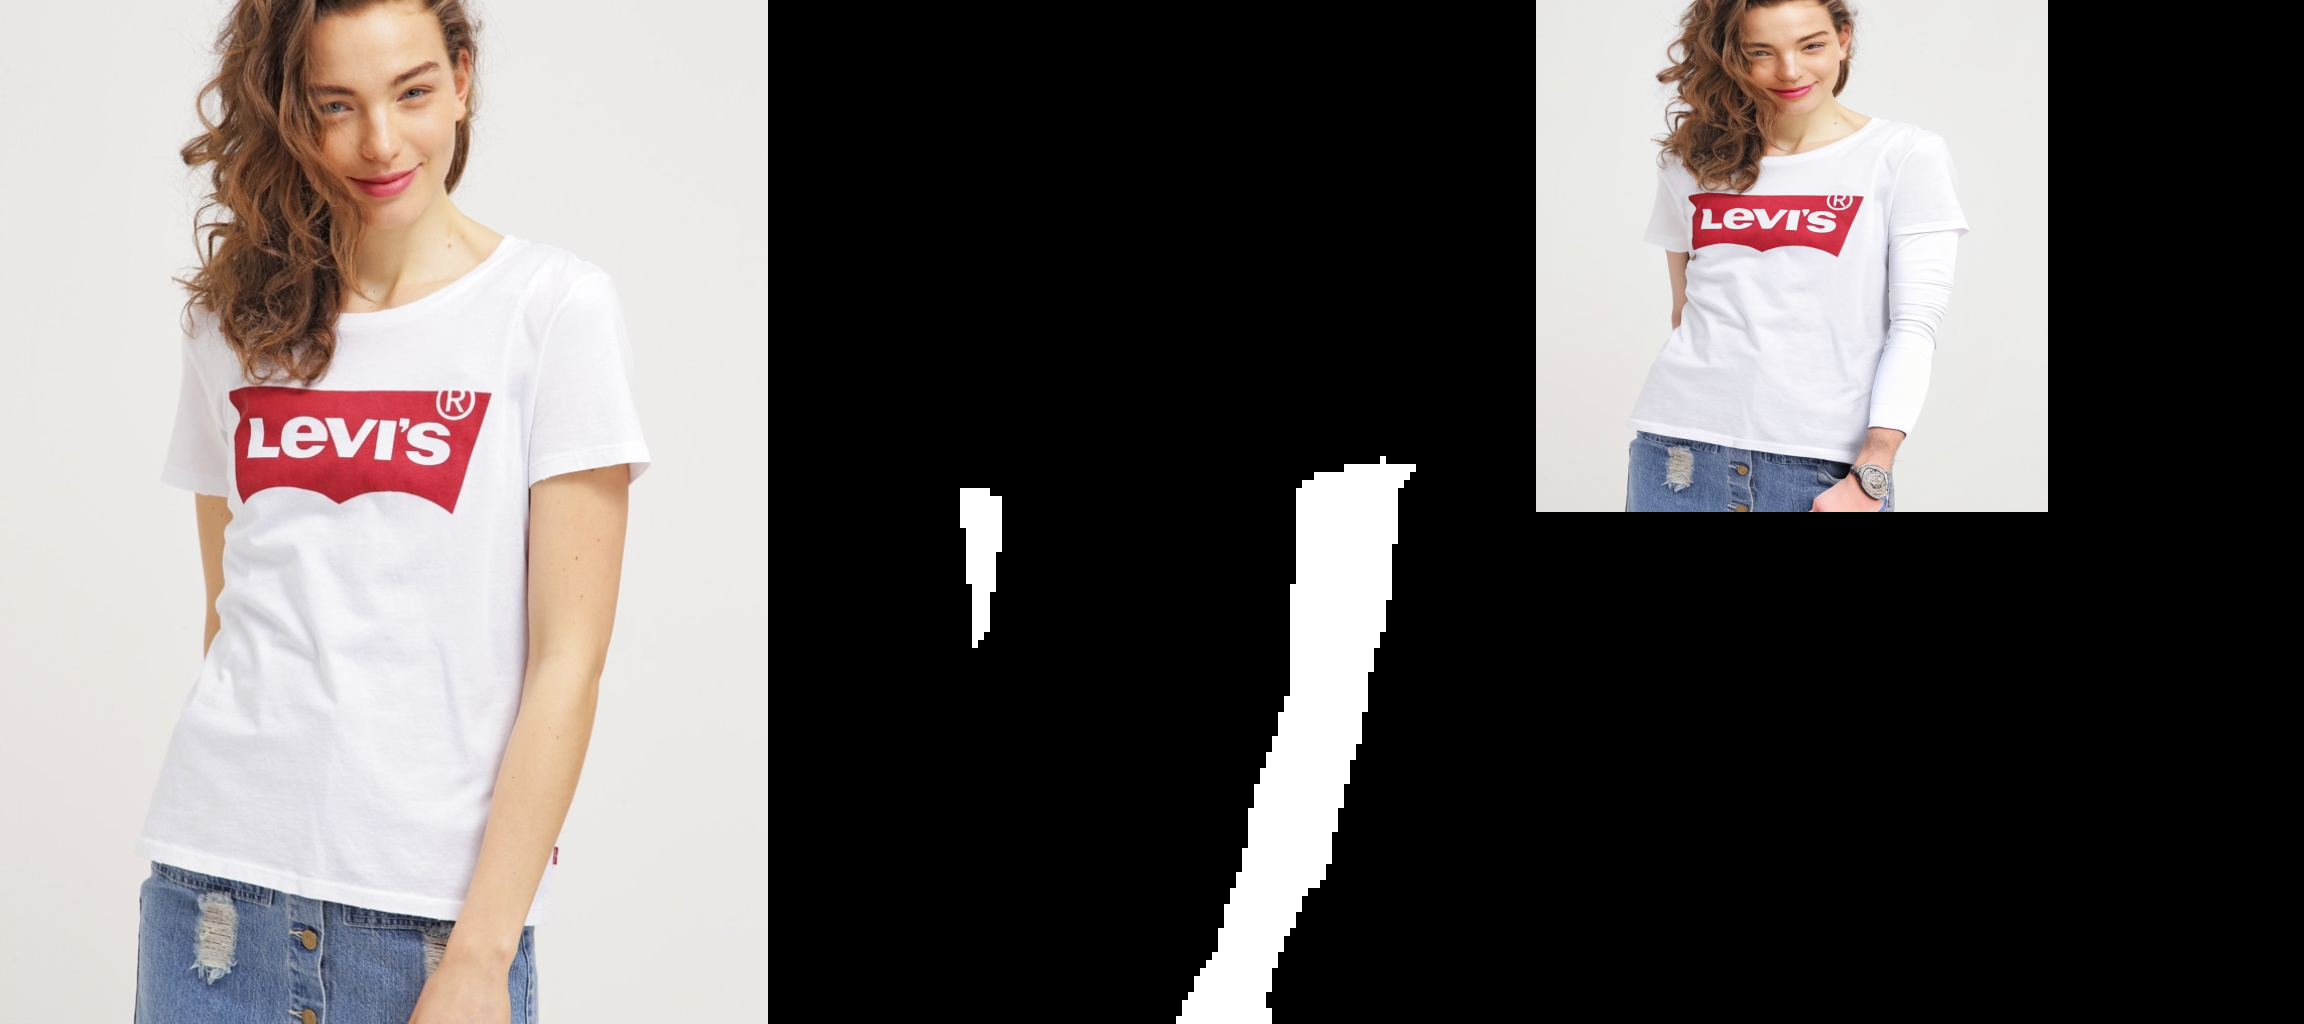

In [23]:
prompt = "make the tshirt long sleeves with same colour and print as the tshirt in the original image"
negative_prompt = "print mismatch, colour mismatch, low resolution"
image = pipeline(prompt=prompt, negative_prompt=negative_prompt, image=init_image, mask_image=mask_image).images[0]
make_image_grid([init_image, mask_image, image], rows=1, cols=3)


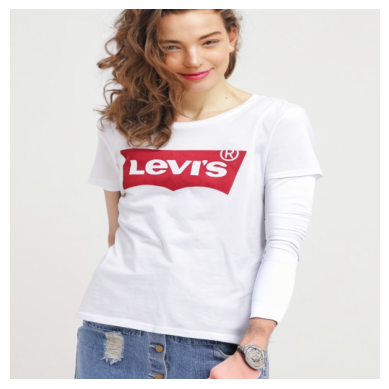

In [24]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.axis('off')
plt.show()

image.save("inpainted_sleeves5.png")
